In [73]:
import pandas as pd
from pathlib import Path

In [74]:
# Import raw data
# https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data
dataset_file = Path("./credit_risk_dataset.csv")
df = pd.read_csv(dataset_file.as_posix())

## Data cleaning

In [75]:
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [76]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [77]:
# Check for missing data
missing_data = df.isnull().sum()[df.isnull().sum() > 0]
missing_data

person_emp_length     895
loan_int_rate        3116
dtype: int64

In [78]:
# Drop duplicates (should we?)
df.drop_duplicates(inplace=True)

# person_emp_length is small enough to drop
df.dropna(subset=['person_emp_length'], inplace=True)

# loan_int_rate we should try to put in a guess for
# Loan interest rate is correlated to grade, so we can use the average interest rate for a grade to put an estimate

median_by_grade = df.groupby('loan_grade')['loan_int_rate'].median()
print(median_by_grade)
# That looks fair enough, let's use that

# Fillna by referencing the loan's grade
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_grade'].map(median_by_grade))

# Verify we cleaned up those issues
assert(df['loan_int_rate'].isnull().sum() == 0) # No null loan interest rates
assert(median_by_grade.equals(df.groupby('loan_grade')['loan_int_rate'].median())) # Didn't change the median
assert(df.isnull().sum().sum() == 0) # No more null values at all

loan_grade
A     7.49
B    10.99
C    13.48
D    15.31
E    16.77
F    18.53
G    20.16
Name: loan_int_rate, dtype: float64


In [79]:
# Remove rows with unreasonable ages
df[df['person_age'] > 105]
# Remove rows where employment length is longer than their age
df[df['person_emp_length'] > df['person_age']]

df = df[df['person_age'] <= 105]
df = df[df['person_emp_length'] <= df['person_age']]

df.reset_index(drop=True, inplace=True)

In [80]:
# Bin ages into categories to simplify model
print(df['person_age'].min(), df['person_age'].max())
bins = [0, 29, 39, 49, 59, 110]
labels = ['20-29', '30-39', '40-49', '50-59', '60+'] # Taken from a FICO chart https://www.fico.com/blogs/age-beauty-credit-worthiness-youth 
df['person_age_bin'] = pd.cut(df['person_age'], bins, labels=labels)
df[df['person_age'] > 47]

20 94


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_age_bin
28157,50,900000,MORTGAGE,11.0,DEBTCONSOLIDATION,B,30000,12.69,0,0.03,N,15,50-59
28196,48,228000,MORTGAGE,0.0,HOMEIMPROVEMENT,D,25000,15.31,1,0.11,N,13,40-49
28214,50,200000,RENT,1.0,PERSONAL,B,7000,10.99,0,0.04,N,15,50-59
28243,49,142800,MORTGAGE,3.0,MEDICAL,B,24000,10.99,1,0.14,N,14,40-49
28275,48,16800,OWN,0.0,HOMEIMPROVEMENT,B,3300,10.99,1,0.20,N,14,40-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31517,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30,50-59
31518,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19,50-59
31519,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28,60+
31520,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26,50-59


In [81]:
# Set columns as categorical
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'person_age_bin']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Test that worked
df['loan_intent'].cat.categories

Index(['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL',
       'PERSONAL', 'VENTURE'],
      dtype='object')

## Initial inspection

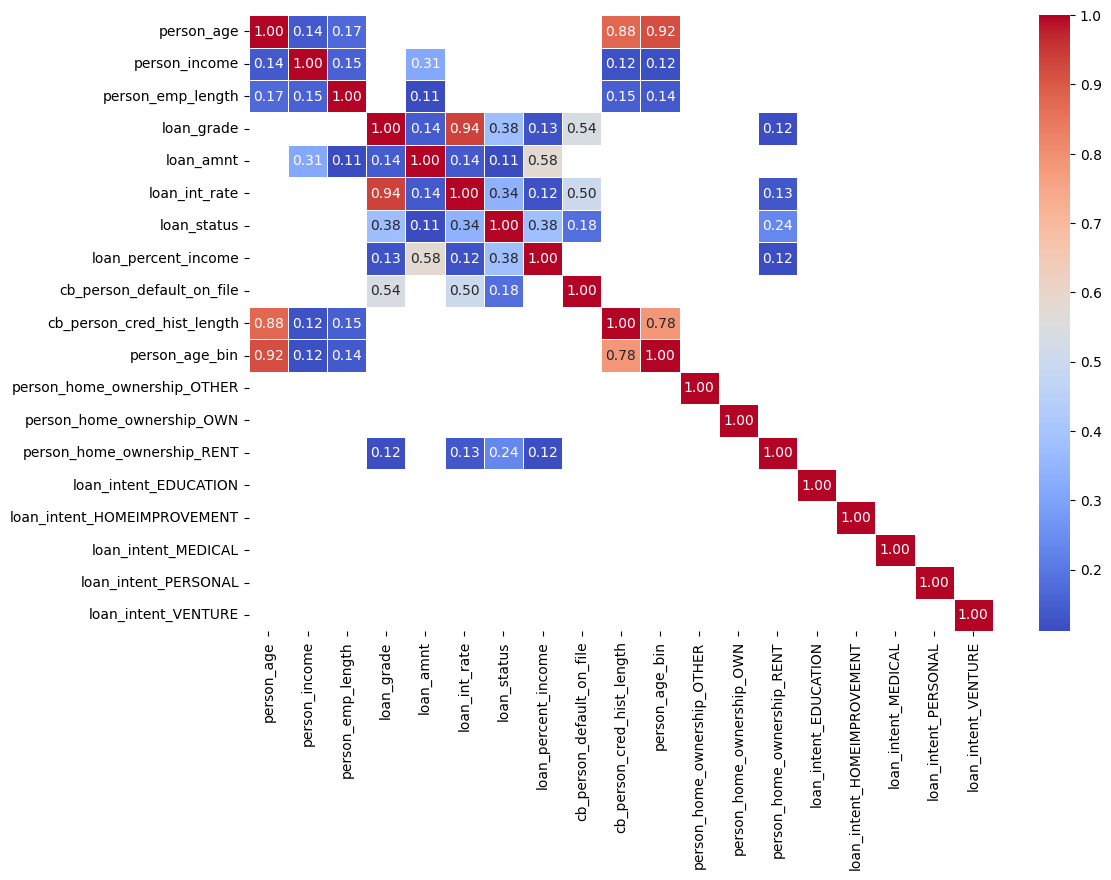

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix

# Need to one-hot encode categorical features first
encoded_df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'], drop_first=True)
encoded_df['loan_grade'] = encoded_df['loan_grade'].cat.codes
encoded_df['cb_person_default_on_file'] = encoded_df['cb_person_default_on_file'].cat.codes
encoded_df['person_age_bin'] = encoded_df['person_age_bin'].cat.codes

corr = encoded_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=corr < 0.1)
plt.show()

## Sklearn

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
standardize = StandardScaler() 
#standardize all scalar variables 
scalar_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
df[scalar_features] = standardize.fit_transform(df[scalar_features])

X = pd.concat([encoded_df, df[scalar_features]], axis=1).drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# random forest classifier because ... 
model = RandomForestClassifier(random_state=42, class_weight='balanced') 
# balanced class weight gives more importance to minority cases (1) to improve precision on predicting 1
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4969
           1       0.96      0.69      0.80      1336

    accuracy                           0.93      6305
   macro avg       0.94      0.84      0.88      6305
weighted avg       0.93      0.93      0.92      6305



## Hyperparameter Tuning

### Randomized Search

In [84]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'class_weight': ['balanced', 'balanced_subsample']
}
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_params_random = random_search.best_params_
print("Best Parameters from Random Search:", best_params_random)
best_model_random = random_search.best_estimator_
y_pred = best_model_random.predict(X_test)
print("Classification Report for Random Search Model:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END class_weight=balanced, max_depth=38, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.2s
[CV] END class_weight=balanced, max_depth=38, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.2s
[CV] END class_weight=balanced, max_depth=38, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.2s
[CV] END class_weight=balanced, max_depth=38, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.2s
[CV] END class_weight=balanced, max_depth=38, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   2.2s
[CV] END class_weight=balanced_subsample, max_depth=45, min_samples_leaf=8, min_samples_split=9, n_estimators=230; total time=   4.7s
[CV] END class_weight=balanced_subsample, max_depth=45, min_samples_leaf=8, min_samples_split=9, n_estimators=230; total time=   4.7s
[CV] END class_weight=balanced_subsample, max_dept

### Bayesian Optimization

In [85]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params_bayesian = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params_bayesian)

best_model_bayesian = RandomForestClassifier(
    n_estimators=best_params_bayesian['n_estimators'],
    max_depth=best_params_bayesian['max_depth'],
    min_samples_split=best_params_bayesian['min_samples_split'],
    min_samples_leaf=best_params_bayesian['min_samples_leaf'],
    class_weight=best_params_bayesian['class_weight'],
    random_state=42
)
best_model_bayesian.fit(X_train, y_train)
y_pred = best_model_bayesian.predict(X_test)
print("Classification Report for Bayesian Optimization Model:")
print(classification_report(y_test, y_pred))

/Users/anna/Downloads/GiveMeCredit/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-18 16:21:52,793] A new study created in memory with name: no-name-90772275-ff7f-41f2-94e7-88f7bdbe1f8c
[I 2025-01-18 16:22:09,312] Trial 0 finished with value: 0.7910371230190015 and parameters: {'n_estimators': 264, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 4, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7910371230190015.
[I 2025-01-18 16:23:10,505] Trial 1 finished with value: 0.8163795306220273 and parameters: {'n_estimators': 815, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8163795306220273.
[I 2025-01-18 16:23:57,608] Trial 2 finished with value: 0.7795598859850952 and p

Best Parameters from Bayesian Optimization: {'n_estimators': 642, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}
Classification Report for Bayesian Optimization Model:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4969
           1       0.95      0.71      0.81      1336

    accuracy                           0.93      6305
   macro avg       0.94      0.85      0.88      6305
weighted avg       0.93      0.93      0.93      6305

